In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import pytz
import numpy as np
from matplotlib.patches import Rectangle
from IPython.display import display

kilburn = [30,31,32,33]

bookings = pd.read_json("../../chatbot_data/bookings/bookings13-11-23.json")

bookings = pd.DataFrame(bookings.fields.values.tolist())

# switch to a faster method of parsing datetime strings by inferring the format
bookings['start'] = pd.to_datetime(bookings['start'],infer_datetime_format=True).dt.floor('S')
bookings['created_at'] = pd.to_datetime(bookings['created_at'],infer_datetime_format=True).dt.floor('S')
bookings['modified_at'] = pd.to_datetime(bookings['modified_at'],infer_datetime_format=True).dt.floor('S')

coordinationStartDate = datetime.datetime(2023,10,18,0,0,0,0,tzinfo=pytz.timezone('UTC'))
validBookings = bookings.loc[bookings['start']>= coordinationStartDate] 

klbBookings = validBookings.loc[validBookings['user'].isin(kilburn)].copy()
klbBookings

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at
127,2023-10-20 11:00:00+00:00,5400,laundry,None,yes,0.474828,32,electricity_consumption,30,2023-10-19 22:06:27+00:00,2023-10-19 22:06:27+00:00
129,2023-10-20 10:00:00+00:00,4800,laundry,None,yes,0.360819,23,electricity_consumption,32,2023-10-20 08:54:59+00:00,2023-10-20 08:54:59+00:00
131,2023-10-20 16:00:00+00:00,3600,oven,None,yes,0.488376,32,electricity_consumption,30,2023-10-20 11:03:48+00:00,2023-10-20 11:03:48+00:00
134,2023-10-20 17:00:00+00:00,3600,dishwasher,None,yes,0.461472,23,electricity_consumption,32,2023-10-20 16:54:07+00:00,2023-10-20 16:54:07+00:00
139,2023-10-21 10:00:00+00:00,3600,laundry,None,yes,0.270614,23,electricity_consumption,32,2023-10-21 09:30:04+00:00,2023-10-21 09:30:04+00:00
...,...,...,...,...,...,...,...,...,...,...,...
260,2023-11-08 13:00:00+00:00,7200,laundry,,no,1.320000,31,electricity_consumption,31,2023-11-08 12:37:19+00:00,2023-11-08 12:37:19+00:00
261,2023-11-09 09:00:00+00:00,3600,hob,,yes,0.350000,32,electricity_consumption,30,2023-11-08 17:39:59+00:00,2023-11-08 17:39:59+00:00
262,2023-11-08 19:45:00+00:00,3600,dishwasher,Don’t want to do it too late,somewhat,0.460000,23,electricity_consumption,32,2023-11-08 19:33:53+00:00,2023-11-08 19:33:53+00:00
263,2023-11-09 08:00:00+00:00,3600,dishwasher,,no,0.450000,31,electricity_consumption,31,2023-11-09 07:54:20+00:00,2023-11-09 07:54:20+00:00


85 bookings were made by group Kilburn.
0 of those bookings were modified.


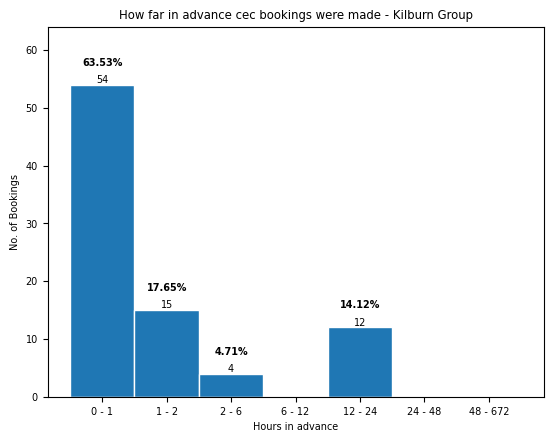

In [4]:
# Kilburn Group Analysis

# How far in advance was a booking made in hours?
klbBookings['diff'] = (klbBookings['start'] - klbBookings['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 7})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(klbBookings['diff'],bins)

# make modified bookings histogram
modified_bookings = klbBookings['diff'].where(klbBookings['modified_at'] > klbBookings['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)])

ax.set_xlabel("Hours in advance")
ax.set_ylabel("No. of Bookings")

# Add the title to the histogram
ax.set_title("How far in advance cec bookings were made - Kilburn Group")

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(klbBookings)
print(total_bookings, 'bookings were made by group Kilburn.')
print(modified_bookings.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all pilot group bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
    
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in pilot group
for i, bar in enumerate(nested_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = max(hist) + 10  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('group_kilburn_cec_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# User 30 -  Sara

bookingsUser30 = klbBookings.loc[klbBookings['user'] == 30].copy()

bookingsUser30

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
127,2023-10-20 11:00:00+00:00,5400,laundry,None,yes,0.474828,32,electricity_consumption,30,2023-10-19 22:06:27+00:00,2023-10-19 22:06:27+00:00,12.892500
131,2023-10-20 16:00:00+00:00,3600,oven,None,yes,0.488376,32,electricity_consumption,30,2023-10-20 11:03:48+00:00,2023-10-20 11:03:48+00:00,4.936667
140,2023-10-21 16:00:00+00:00,1800,hob,None,yes,0.256945,32,electricity_consumption,30,2023-10-21 10:28:42+00:00,2023-10-21 10:28:42+00:00,5.521667
148,2023-10-22 11:00:00+00:00,5400,laundry,None,yes,0.474828,32,electricity_consumption,30,2023-10-22 10:48:36+00:00,2023-10-22 10:48:36+00:00,0.190000
150,2023-10-22 16:00:00+00:00,1800,oven,None,yes,0.244188,32,electricity_consumption,30,2023-10-22 15:17:19+00:00,2023-10-22 15:17:19+00:00,0.711389
155,2023-10-23 16:00:00+00:00,1500,hob,None,yes,0.214121,32,electricity_consumption,30,2023-10-23 14:19:34+00:00,2023-10-23 14:19:34+00:00,1.673889
156,2023-10-24 09:00:00+00:00,5400,laundry,None,yes,0.474828,32,electricity_consumption,30,2023-10-24 08:38:15+00:00,2023-10-24 08:38:15+00:00,0.362500
162,2023-10-25 16:00:00+00:00,3600,hob,None,yes,0.513891,32,electricity_consumption,30,2023-10-25 13:27:41+00:00,2023-10-25 13:27:41+00:00,2.538611
174,2023-10-26 16:00:00+00:00,1800,hob,None,yes,0.256945,32,electricity_consumption,30,2023-10-26 14:09:03+00:00,2023-10-26 14:09:03+00:00,1.849167
187,2023-10-28 11:00:00+00:00,5400,laundry,None,yes,0.474828,32,electricity_consumption,30,2023-10-28 10:07:44+00:00,2023-10-28 10:07:44+00:00,0.871111


29 bookings were made by User 30 - Sara.
0 of those bookings were modified.


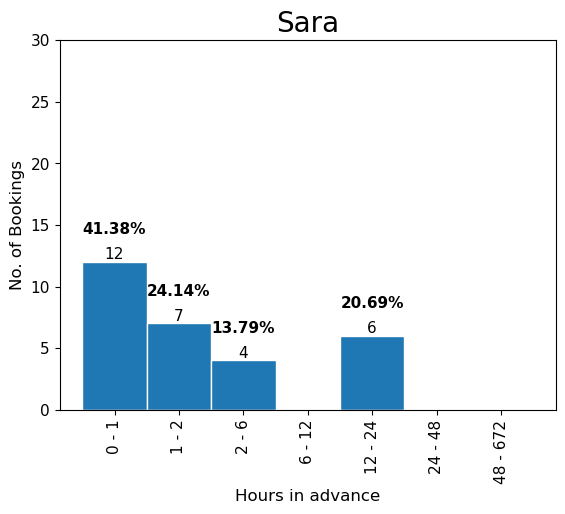

In [18]:
# Booking pattern for User 30

# How far in advance was a booking made in hours?
bookingsUser30['diff'] = (bookingsUser30['start'] - bookingsUser30['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser30['diff'],bins)

# make modified bookings histogram
modified_bookings_user_30 = bookingsUser30['diff'].where(bookingsUser30['modified_at'] > bookingsUser30['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_30, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Sara", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser30)
print(total_bookings, 'bookings were made by User 30 - Sara.')
print(modified_bookings_user_30.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 30 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 27
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 30  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('sara_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# User 31 - Adam

bookingsUser31 = klbBookings.loc[klbBookings['user'] == 31].copy()

bookingsUser31

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
145,2023-10-22 08:00:00+00:00,5400,laundry,None,yes,0.921050,31,electricity_consumption,31,2023-10-21 19:10:50+00:00,2023-10-21 19:10:50+00:00,12.819444
172,2023-10-26 12:00:00+00:00,5400,laundry,None,yes,0.921050,31,electricity_consumption,31,2023-10-26 11:34:42+00:00,2023-10-26 11:34:42+00:00,0.421667
177,2023-10-27 08:00:00+00:00,3600,dishwasher,None,yes,0.550633,31,electricity_consumption,31,2023-10-27 07:00:42+00:00,2023-10-27 07:00:42+00:00,0.988333
186,2023-10-28 08:00:00+00:00,3600,dishwasher,None,yes,0.550633,31,electricity_consumption,31,2023-10-28 07:34:45+00:00,2023-10-28 07:34:45+00:00,0.420833
190,2023-10-29 10:00:00+00:00,18000,dishwasher,None,yes,2.753164,31,electricity_consumption,31,2023-10-29 09:43:46+00:00,2023-10-29 09:43:46+00:00,0.270556
196,2023-10-30 08:00:00+00:00,3600,dishwasher,None,yes,0.550633,31,electricity_consumption,31,2023-10-30 07:28:02+00:00,2023-10-30 07:28:02+00:00,0.532778
206,2023-10-31 09:00:00+00:00,3600,dishwasher,None,yes,0.550633,31,electricity_consumption,31,2023-10-31 07:51:54+00:00,2023-10-31 07:51:54+00:00,1.135000
207,2023-10-31 09:00:00+00:00,7200,laundry,None,yes,1.228066,31,electricity_consumption,31,2023-10-31 07:52:42+00:00,2023-10-31 07:52:42+00:00,1.121667
217,2023-11-01 10:00:00+00:00,5400,laundry,None,yes,0.921050,31,electricity_consumption,31,2023-11-01 09:53:05+00:00,2023-11-01 09:53:05+00:00,0.115278
219,2023-11-01 14:00:00+00:00,3600,dishwasher,None,yes,0.550633,31,electricity_consumption,31,2023-11-01 13:22:07+00:00,2023-11-01 13:22:07+00:00,0.631389


23 bookings were made by User 31 - Adam.
0 of those bookings were modified.


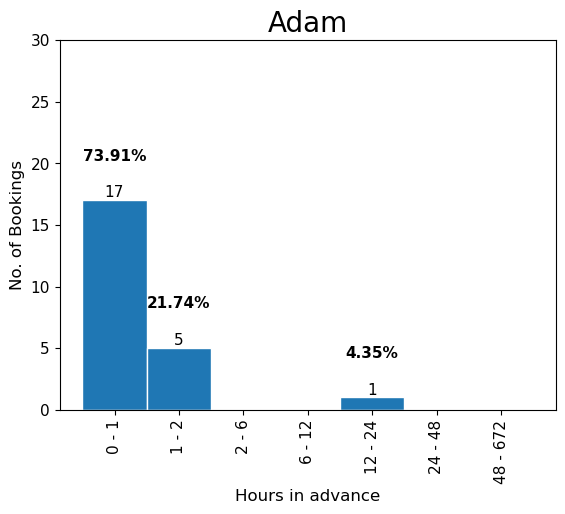

In [17]:
# Booking pattern for User 31

# How far in advance was a booking made in hours?
bookingsUser31['diff'] = (bookingsUser31['start'] - bookingsUser31['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser31['diff'],bins)

# make modified bookings histogram
modified_bookings_user_31 = bookingsUser31['diff'].where(bookingsUser31['modified_at'] > bookingsUser31['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_31, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Adam", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser31)
print(total_bookings, 'bookings were made by User 31 - Adam.')
print(modified_bookings_user_31.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 31 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 31
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 30 # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('adam_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# User 32 - Ute

bookingsUser32 = klbBookings.loc[klbBookings['user'] == 32].copy()

bookingsUser32

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
129,2023-10-20 10:00:00+00:00,4800,laundry,None,yes,0.360819,23,electricity_consumption,32,2023-10-20 08:54:59+00:00,2023-10-20 08:54:59+00:00,1.083611
134,2023-10-20 17:00:00+00:00,3600,dishwasher,None,yes,0.461472,23,electricity_consumption,32,2023-10-20 16:54:07+00:00,2023-10-20 16:54:07+00:00,0.098056
139,2023-10-21 10:00:00+00:00,3600,laundry,None,yes,0.270614,23,electricity_consumption,32,2023-10-21 09:30:04+00:00,2023-10-21 09:30:04+00:00,0.498889
146,2023-10-22 09:00:00+00:00,3600,dishwasher,None,yes,0.461472,23,electricity_consumption,32,2023-10-22 08:42:42+00:00,2023-10-22 08:42:42+00:00,0.288333
160,2023-10-25 10:00:00+00:00,4800,laundry,None,yes,0.360819,23,electricity_consumption,32,2023-10-25 09:14:48+00:00,2023-10-25 09:14:48+00:00,0.753333
163,2023-10-25 18:00:00+00:00,7200,dishwasher,None,yes,0.922945,23,electricity_consumption,32,2023-10-25 17:47:36+00:00,2023-10-25 17:47:36+00:00,0.206667
170,2023-10-26 10:00:00+00:00,6000,laundry,None,yes,0.451024,23,electricity_consumption,32,2023-10-26 09:29:54+00:00,2023-10-26 09:29:54+00:00,0.501667
176,2023-10-26 17:00:00+00:00,6000,laundry,None,yes,0.451024,23,electricity_consumption,32,2023-10-26 16:11:27+00:00,2023-10-26 16:11:27+00:00,0.809167
180,2023-10-27 14:00:00+00:00,6000,laundry,None,yes,0.451024,23,electricity_consumption,32,2023-10-27 13:41:02+00:00,2023-10-27 13:41:02+00:00,0.316111
194,2023-10-29 17:00:00+00:00,6000,laundry,None,yes,0.451024,23,electricity_consumption,32,2023-10-29 16:58:58+00:00,2023-10-29 16:58:58+00:00,0.017222


28 bookings were made by User 32 - Ute.
0 of those bookings were modified.


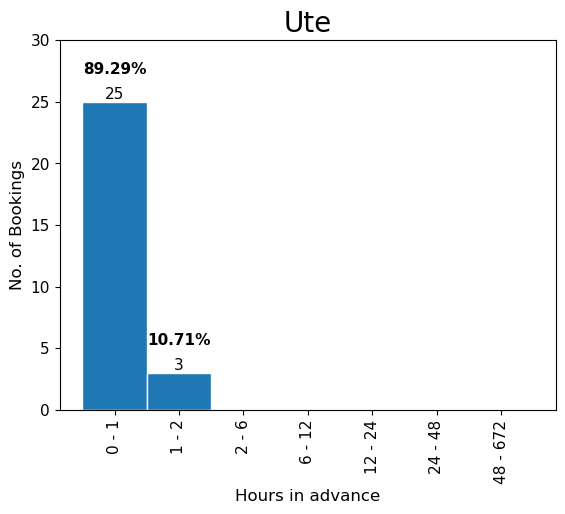

In [16]:
# Booking pattern for User 32 - Ute

# How far in advance was a booking made in hours?
bookingsUser32['diff'] = (bookingsUser32['start'] - bookingsUser32['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser32['diff'],bins)

# make modified bookings histogram
modified_bookings_user_32 = bookingsUser32['diff'].where(bookingsUser32['modified_at'] > bookingsUser32['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_32, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Ute", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser32)
print(total_bookings, 'bookings were made by User 32 - Ute.')
print(modified_bookings_user_32.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 25 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 25
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 30  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('ute_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# User 33 - Dannie

bookingsUser33 = klbBookings.loc[klbBookings['user'] == 33].copy()

bookingsUser33

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
151,2023-10-23 10:00:00+00:00,3600,laundry,None,yes,1.312278,37,electricity_consumption,33,2023-10-22 18:30:15+00:00,2023-10-22 18:30:15+00:00,15.495833
167,2023-10-26 18:00:00+00:00,3600,dinner,None,yes,0.489370,37,electricity_consumption,33,2023-10-25 19:47:39+00:00,2023-10-25 19:47:39+00:00,22.205833
168,2023-10-26 13:00:00+00:00,3600,special_event,None,yes,1.530843,37,electricity_consumption,33,2023-10-25 19:48:15+00:00,2023-10-25 19:48:15+00:00,17.195833
220,2023-11-02 11:00:00+00:00,5400,laundry,None,yes,1.968417,37,electricity_consumption,33,2023-11-01 19:31:49+00:00,2023-11-01 19:31:49+00:00,15.469722
224,2023-11-04 12:00:00+00:00,1800,oven,,yes,0.550000,37,electricity_consumption,33,2023-11-03 21:47:57+00:00,2023-11-03 21:47:57+00:00,14.200833


5 bookings were made by User 33 - Dannie.
0 of those bookings were modified.


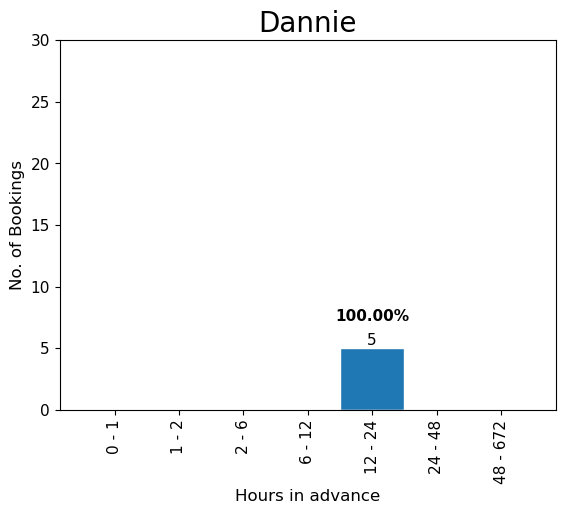

In [21]:
# Booking pattern for User 33 - Dannie

# How far in advance was a booking made in hours?
bookingsUser33['diff'] = (bookingsUser33['start'] - bookingsUser33['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser33['diff'],bins)

# make modified bookings histogram
modified_bookings_user_33 = bookingsUser33['diff'].where(bookingsUser33['modified_at'] > bookingsUser33['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_33, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Dannie", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser33)
print(total_bookings, 'bookings were made by User 33 - Dannie.')
print(modified_bookings_user_33.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 24 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 24
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 30  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('dannie_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()